In [3]:
%matplotlib inline

In [5]:
import pandas as pd
import os
import xarray as xr
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../source')

from pandas.plotting import register_matplotlib_converters
from constants import MOORING_DIRPATH, REANALYSIS_DIRPATH

In [6]:
def read_bs(fili):
    """
    Reads text file containing Bering Strait flux data into Pandas DataFrame
    """
    df = pd.read_csv(fili, header=None, comment='%',sep='\s+', 
                 names=['Mooring', 'Year', 'Month', 'Mean', 'Error', 'MeanCorr', 'CorrErr'],
                 parse_dates={'time': ['Year', 'Month']}, index_col='time')
    return df

## Read Bearing Strait heat flux and convert to DataArray

In [7]:
#diri = r'C:\Users\apbarret\Documents\data\BeringStraitHeatFlux'
#diri = '/home/apbarret/data/BeringStraitHeatFlux/Mooring'
fili = r'BeringStrait_Monthlymeans_TRANSPORT_Oct2017.txt'
df = read_bs(os.path.join(MOORING_DIRPATH, 'Month', fili))
heat = xr.DataArray.from_series(df['MeanCorr'])

/home/apbarret/anaconda3/envs/seaicealbedo_update_dask/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'TW')

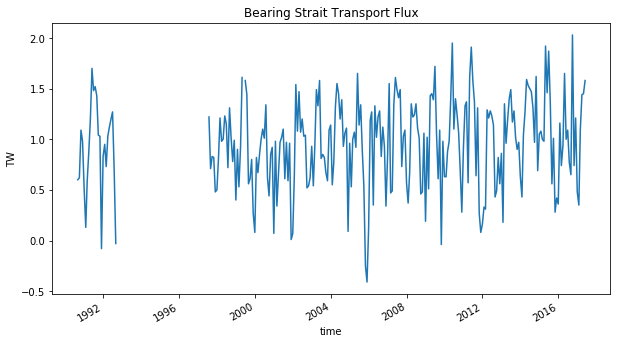

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
heat.plot(ax=ax)
ax.set_title('Bearing Strait Transport Flux')
ax.set_ylabel('TW')

## Get winds

In [ ]:
#reanalysis_dir = '/disks/arctic5_raid/abarrett/MERRA2/monthly'
ncfile = 'MERRA2_400.instM_2d_asm_Nx.U10M.month.1980to2018.nc4'
u10m = xr.open_dataset(os.path.join(REANALYSIS_DIRPATH, 'U10M', ncfile))
u10m = u10m['U10M'].loc[dict(time=slice('1990-01-01','2017-12-01'), lat=slice(20,90))]

#reanalysis_dir = '/disks/arctic5_raid/abarrett/MERRA2/monthly'
ncfile = 'MERRA2_400.instM_2d_asm_Nx.V10M.month.1980to2018.nc4'
v10m = xr.open_dataset(os.path.join(REANALYSIS_DIRPATH, 'V10M', ncfile))
v10m = v10m['V10M'].loc[dict(time=slice('1990-01-01','2017-12-01'), lat=slice(20,90))]

print (u10m)
print (v10m)

## Rotate winds relative to 330 deg. N

I use affine for this.  Affine.rotation returns a rotation matrix.  This can then be used to post-multiply a tuple of u and v winds

In [ ]:
from affine import Affine

relative_wind_direction = 330.
fwd = Affine.rotation(relative_wind_direction)
u10m_rot, v10m_rot = (u10m, v10m)*fwd

## Calculate correlation coeficient
I haven't figured out how to do this in one fell swoop, so I do it in several steps.
1. Calculate anomaly time series in time dimensions for U10M and heat flux
2. Calculate gridcell covariances between the two data sets
3. Calculate standard deviations for the two data sets
4. Calculate correlation coeficients for each grid cell

### Step 0.  Remove months with missing data (NaNs)

In [ ]:
heat = heat.dropna(dim='time')
u10m_rot = u10m_rot.where(xr.ufuncs.isfinite(heat), drop=True)

### Step 1.  Calculate anomaly time series

In [ ]:
def anomaly(x, dim=None):
    return x - x.mean(dim=dim)

In [ ]:
heatAnom = heat.groupby('time.month').apply(anomaly)
u10m_rotAnom = u10m_rot.groupby('time.month').apply(anomaly, dim='time')

### Step 2. Calculate covariance

In [ ]:
cov = (u10m_rotAnom * heatAnom).groupby('time.month').mean(dim='time')

### Step 3. Calculate standard deviations

In [ ]:
heatStd = heat.groupby('time.month').std(dim='time')
u10m_rotStd = u10m_rot.groupby('time.month').std(dim='time')

In [ ]:
print (cov.shape)
print (heatStd.shape)
print (u10m_rotStd.shape)

### Step 4. Calculate correlation coeficient

In [ ]:
corrcoef = cov / (heatStd * u10m_rotStd)

In [ ]:
from scipy import stats

# calculate t-statistic
n = heat.groupby('time.month').count()
dgf = np.sqrt(n - 2)
den = np.sqrt(1 - (corrcoef*corrcoef))
t = corrcoef*dgf / den

p = 1 - stats.t.cdf(np.abs(t), 21)
r = corrcoef.where(2*p < 0.05)

## Plot results

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl

In [ ]:
r

In [ ]:
fig = plt.figure(figsize=(12, 9))

land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor=0.5)

cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=-1., vmax=1.)

ax = []
monthstr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
square = mpath.Path([[0.,1.],[0.8,1.],[0.8,0.2],[0.,0.2]])  # Boundary to crop map

for i, mstr in enumerate(monthstr):
        
    ax.append( plt.subplot(3, 4, i+1, projection=ccrs.NorthPolarStereo()) )
    
    ax[i].set_extent([-180.,180.,55.,90.], ccrs.PlateCarree())
    #cax = r.isel(month=i).plot(ax=ax[i], transform=ccrs.PlateCarree(), add_colorbar=False, 
    #                           norm=norm, cmap=cmap)
    ax[i].contourf(r.lon, r.lat, r.isel(month=i), transform=ccrs.PlateCarree(), 
                    norm=norm, cmap=cmap)
    #ax[i].pcolormesh(r.lon, r.lat, r.isel(month=i), transform=ccrs.PlateCarree(), 
    #                norm=norm, cmap=cmap, clip_path=(square, ax[i].transAxes))
    ax[i].coastlines()
    #ax[i].add_feature(land, zorder=1)
    ax[i].set_title(mstr)

    #ax[i].set_boundary(square, transform=ax[i].transAxes)

axc = fig.add_axes([0.2, 0.05, 0.6, 0.03])
cbar = mpl.colorbar.ColorbarBase(axc, orientation='horizontal', norm=norm, cmap=cmap)

#fig.savefig(os.path.join(diri,'MERRA2_U10M_BSTrans_Correlation_Month_rot330.png'))
#ax.add_feature(cfeature.LAND, zorder=1, facecolor=0.3)